Assorted plots
==============

This contains lots of plots from runs over the last few days (around 15 to 22 July).

It's kind of like the sequel to `ota-basic.py`.

In [1]:
import csv
import json
import random
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# copied from ota-basic.ipynb

abbreviations = {'parameter_radius': 'B', 'noise': 'σₙ²', 'clients': 'n', 'power': 'P', 'data_per_client': 'dpc', 'quantization_range': 'qr', 'zero_bits_strategy': 'zbs'}

def get_args(directory):
    """`directory` must be a pathlib.Path object."""
    argsfile = directory / 'arguments.json'
    with open(argsfile) as f:
        content = json.load(f)
    return content['args']

def get_eval(directory):
    """`directory` must be a pathlib.Path object."""
    argsfile = directory / 'evaluation.json'
    with open(argsfile) as f:
        content = json.load(f)
    return content

def fits_spec(args, specs):
    """Returns True if the given `args` dict matches the given `specs` dict,
    for those entries in `specs`."""
    for key, value in specs.items():
        arg = args[key]
        if value == "__all__":  # magic value
            matches = True
        elif isinstance(value, list):
            matches = arg in value
        else:
            matches = (arg == value)
        if not matches:
            return False
    return True

In [3]:
# This cell contains the main plotting functions, and some helper functions with common functionality

# Helper functions

def all_subdirectories(results_dir):
    """Returns a list with all subdirectories in `results_dir`.

    `results_dir` should be either a `pathlib.Path` or a list of `pathlib.Path`s.
    In the latter case, the generator goes through each directory in the list in
    turn.
    """
    if not isinstance(results_dir, list):
        results_dir = [results_dir]
    # We could implement this as a generator, but the code ends up being more unwieldy.
    directories = [e 
                   for rd in results_dir 
                   for d in rd.iterdir() if d.is_dir() 
                   for e in d.iterdir() if e.is_dir()]
    return directories

def fits_all_specs(args, title_specs, fixed_specs, series_specs, ignore_specs):
    """Checks if the `args` satisfy all of the `specs`. An assertion fails if:
     - any argument key is not found in the specs or vice versa
     - the arguments do not fit the `title_specs` or `fixed_specs`
    If the assertions do not fail, then this returns True if the `args` satisfy
    `series_specs`, and False if not.
    """
    found_args = set(args.keys())
    specified_args = set(title_specs) | set(fixed_specs) | set(series_specs) | ignore_specs
    assert found_args <= specified_args, "found but not specified: " + str(found_args - specified_args)
    assert specified_args <= found_args, "specified but not found: " + str(specified_args - found_args)
    assert fits_spec(args, fixed_specs)
    assert fits_spec(args, title_specs)
    return fits_spec(args, series_specs)
    
def specs_string(specs):
    """Returns a string suitable for representing the keys and values in `specs`.
    `specs` should be something yielding 2-tuples `(key, value)`. If you want to
    pass in a `dict`, use the `dict.items()` method."""
    return ", ".join(f"{abbreviations.get(key, key)}={value}" for key, value in specs)
        
def plot_all_dataframes(dataframes: dict, title_specs: dict, xlabel: str):
    """Plots all dataframes in `dataframes`, which is expected to be a dict of
    `pandas.DataFrame` objects. `title_specs` is used to generate a suffix for
    the title."""
    plot_cols = 2 if len(dataframes) >= 2 else 1
    plot_rows = (len(dataframes) + 1) // 2  # round up
    figsize = (8*plot_cols, 5*plot_rows)
    fig, axs = plt.subplots(plot_rows, plot_cols, figsize=figsize, squeeze=False, sharex=True)
    axs = axs.flatten()
    
    title_suffix = specs_string(title_specs.items())
    
    for ax, (field, dataframe) in zip(axs, dataframes.items()):
        dataframe.plot(ax=ax)
        ax.legend()
        ax.set_xlabel(xlabel)
        ax.set_ylabel(field)
        ax.set_title(field + "\n" + title_suffix)

# Main plotting functions

def plot_averaged_training_charts(results_dir: Path, fields: list, title_specs: dict,
                                  fixed_specs: dict, series_specs: dict, retval=False):
    """Plots training charts (i.e., metrics vs round number) from the results
    in `results_dir`, for each of the metrics specified in `fields`.
    
    `title_specs` and `fixed_specs` are dicts indicating arguments that should always
    match (an assertion fails if any do not match). `series_spec` is a similar dict, 
    but the values should be lists or the special string `"__all__"`, and this dict is 
    used to differentiate between series.
    
    All arguments must be in one of the three `specs` dicts. This is to protect against
    accidentally averaging mismatched data. An assertion fails if an argument is found
    in the results directories that is not in any of these dicts. If you want to skip
    certain values of an argument (e.g., only plot those with a noise level of 0.1),
    such values should be placed in `series_specs` as a list of one item.
    
    If `retval` is true, the data from which the plots are generated is returned.
    """

    # General strategy: Step through each directory, and for each one:
    #  - check that fixed specs match
    #  - determine which series it belongs to based on series specs
    #  - add it to a DataFrame for that series
    # then at the end, take the averages for each DataFrame, and put it in an overall DataFrame.
    # We actually do this for each metric in `fields`, so we track dicts of {field-name: DataFrame}.

    data = {}

    for directory in all_subdirectories(results_dir):
        args = get_args(directory)
        if not fits_all_specs(args, title_specs, fixed_specs, series_specs, {'cpu', 'repeat'}):
            continue
            
        series = tuple(args[key] for key in series_specs.keys())  # identifier for series
        if series not in data:  # don't use setdefault to avoid generating this every time
            data[series] = {field: pd.DataFrame() for field in fields}

        training = pd.read_csv(directory / "training.csv")
        for field in fields:
            data[series][field][directory] = training[field]

    reduced = {field: pd.DataFrame() for field in fields}
    sample_sizes = {}

    # Take averages and put them in new DataFrames
    for series in sorted(data.keys()):  # sort tuples to get sensible series order
        series_name = specs_string(zip(series_specs, series))
        sample_size = data[series][field].shape[1]
        series_name += f" ({sample_size})"
        for field in fields:
            reduced[field][series_name] = data[series][field].mean(axis=1)

    plot_all_dataframes(reduced, title_specs, "round")
    if retval:
        return reduced
    

# function that plots final accuracy vs number of clients, but averaged over many iterations

def plot_evaluation_vs_clients(results_dir: Path, fields: list, title_specs: dict,
                               fixed_specs: dict, series_specs: dict, retval=False):
    """Plots metric vs number of clients from the results in `results_dir`, for each of
    the metrics specified in `fields`.
    
    The `title_specs`, `fixed_specs` and `series_specs` arguments are the same as in 
    `plot_averaged_training_charts()` above."""

    # Similar strategy to plot_averaged_training_charts; there's actually some amount of nonideal
    # code duplication. The main difference is that here we're collecting and averaging for each
    # point, not on a per-series basis.

    clients_range = range(2, 31)
    data = {}

    for directory in all_subdirectories(results_dir):
        args = get_args(directory)
        if not fits_all_specs(args, title_specs, fixed_specs, series_specs, {'cpu', 'repeat', 'clients'}):
            continue

        series = tuple(args[key] for key in series_specs.keys())  # identifier for series
        if series not in data:  # don't use setdefault to avoid generating this every time
            data[series] = {(field, c): [] for field in fields for c in clients_range}

        evaluation = get_eval(directory)
        for field in fields:
            data[series][(field, args['clients'])].append(evaluation[field])

    reduced = {field: pd.DataFrame() for field in fields}

    # Take averages and put them in DataFrames
    for series in sorted(data.keys()):  # sort tuples to get sensible series order
        series_name = specs_string(zip(series_specs, series))
        for field in fields:
            for c in clients_range:
                samples = np.array(data[series][(field, c)])
                reduced[field].loc[c, series_name] = samples.mean()

    plot_all_dataframes(reduced, title_specs, "number of clients")
    if retval:
        return reduced

# Averaged out over many iterations

I ran the $B = 1, \sigma_\mathrm{n}^2 = 0.1$ with 13,333 data samples per client case repeatedly to try to smooth out the graphs above, to get a better idea of expected performance.

These were all done on commit `bef163a`. This after I implemented the class-based framework, so it is probably subject to the bug I noticed in [1b5e659](https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01). However, it won't be extremely noticeable, because all fo the following experiments were done using the same parameters, changing only `clients` (which isn't subject to the bug). Also, the `data_per_client` option isn't subject to the bug, because it's not passed to `Experiment` class constructors in `params`. So basically the only change from defaults was `noise = 0.1`, and there's a good chance the following is actually with `noise = 1.0`, not 0.1 as claimed.

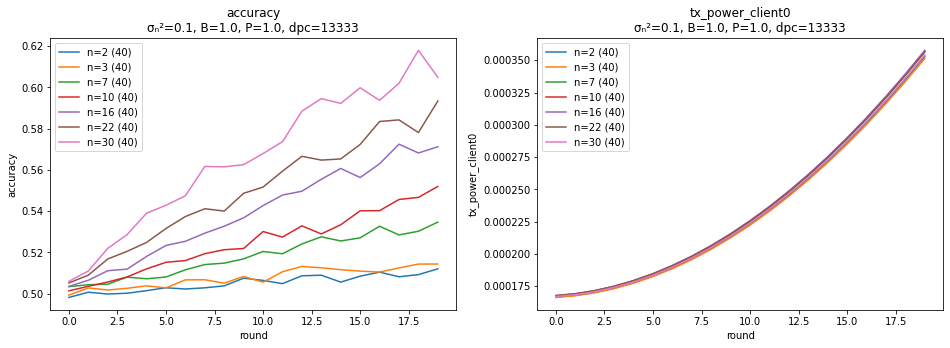

In [4]:
results_dir = Path("../results-downloaded/ota-basic-4/")

title_specs = {
    'noise': 0.1,
    'parameter_radius': 1.0,
    'power': 1.0,
    'data_per_client': 13333,
}
fixed_specs = {
    'rounds': 20,
    'batch_size': 64,
    'lr_client': 0.01,
    'epochs': 1,
    'small': False,
}
series_specs = {
    'clients': [2, 3, 7, 10, 16, 22, 30],
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


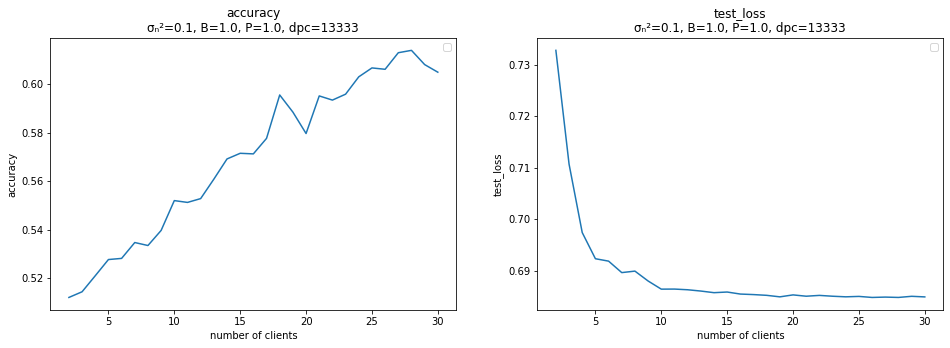

In [5]:
series_specs = {}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Really long experiments on the class-based framework—probably mislabelled

I think these are subject to the bug fixed in commit [`1b5e569`](https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01). See the relevant section below for details. Basically, parameters passed via `params` were probably being ignored. A lot of command-line options weren't necessarily subject to this bug, but some crucial ones were, like `noise`, `power` and `parameter_radius`.

/tmp/ipykernel_29798/3610605507.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[series][field][directory] = training[field]


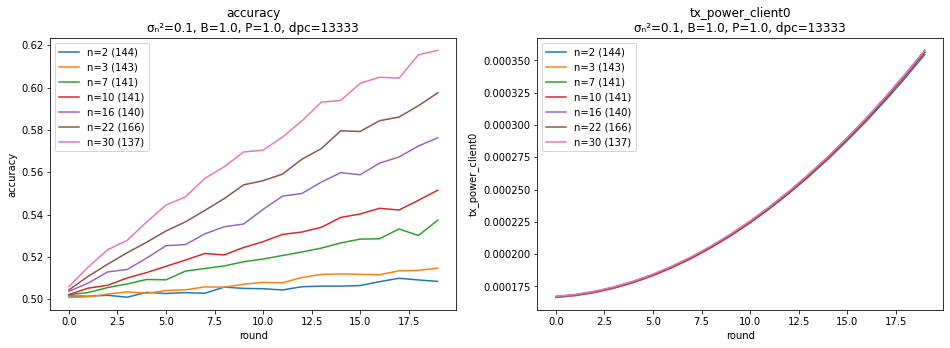

In [6]:
results_dir = Path("../results-downloaded/20210715-20210717-bef163a/")

title_specs = {
    'noise': 0.1,
    'parameter_radius': 1.0,
    'power': 1.0,
    'data_per_client': 13333,
}
series_specs = {
    'clients': [2, 3, 7, 10, 16, 22, 30],
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


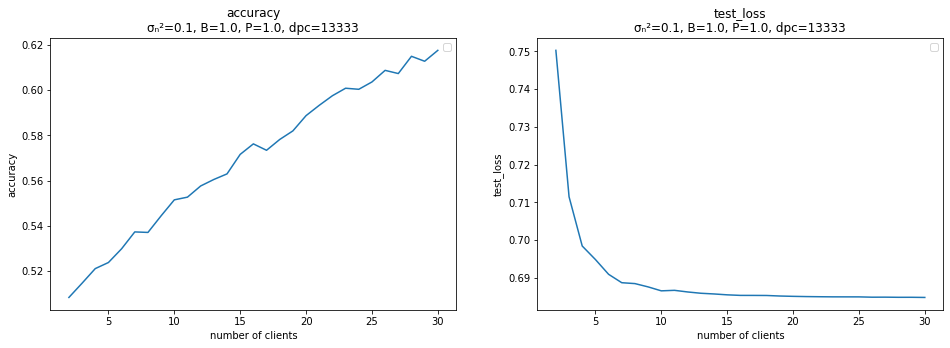

In [7]:
series_specs = {}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Deltas vs params, on commit `9bdb857`—not reliable, discard

These runs didn't run to completion, as in, I stopped them early. This is because I discovered a major bug in parameter handling. See the next section for details, but basically, most command-line arguments were being ignored by the framework.

So I would expect these plots to be identical regardless of what parameters are used, because it's not actually recognizing the parameters!

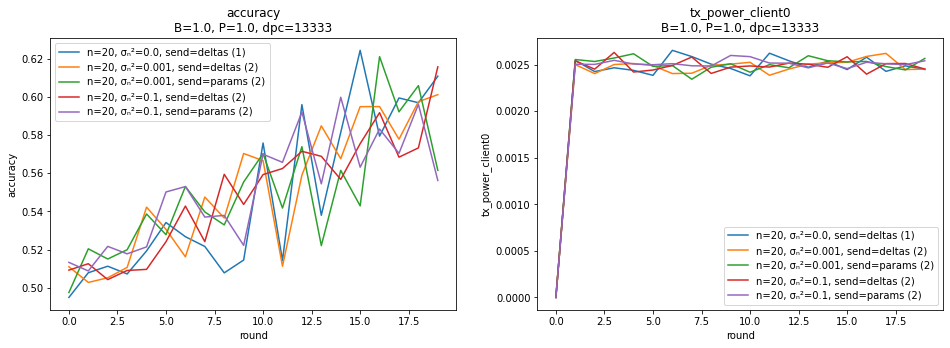

In [8]:
results_dir = Path("../results-downloaded/20210719-9bdb857/")

title_specs = {
    'parameter_radius': 1.0,
    'power': 1.0,
    'data_per_client': 13333,
}
series_specs = {
    'clients': [20],
    'noise': [0.0, 0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

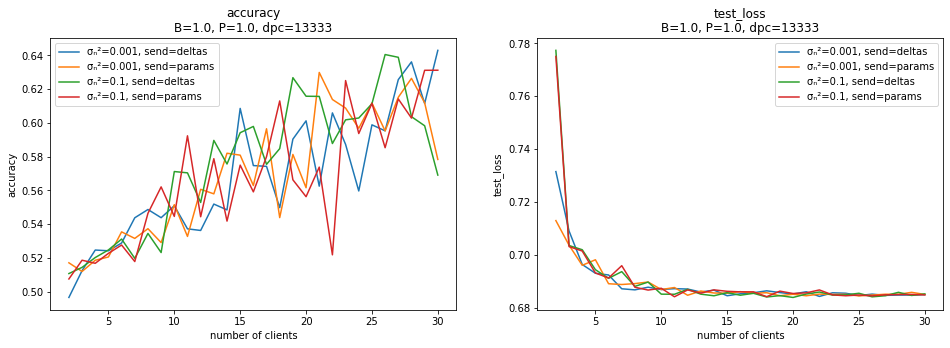

In [9]:
series_specs = {
    'noise': [0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Deltas vs params, on commit `1b5e659`

Okay, here's the fix. You can see this fix here:
> https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01

Or the comparison between this commit and the ones in the following section:
> https://github.com/czlee/jadeite/compare/9bdb857...1b5e659

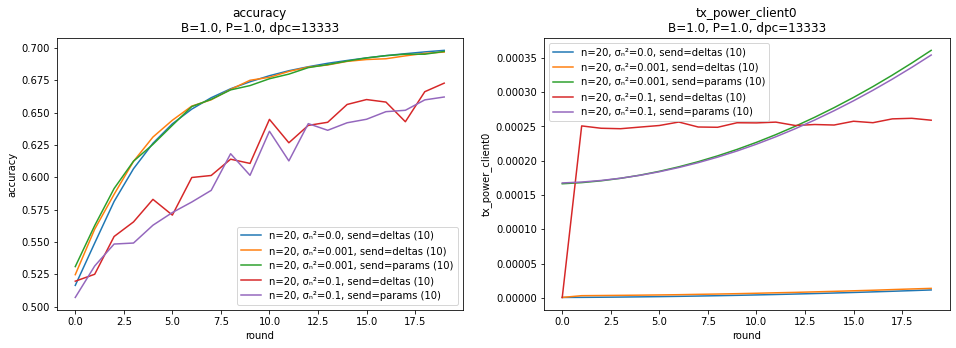

In [10]:
results_dir = Path("../results-downloaded/20210720-1b5e659/")

title_specs = {
    'parameter_radius': 1.0,
    'power': 1.0,
    'data_per_client': 13333,
}
series_specs = {
    'clients': [20],
    'noise': [0.0, 0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

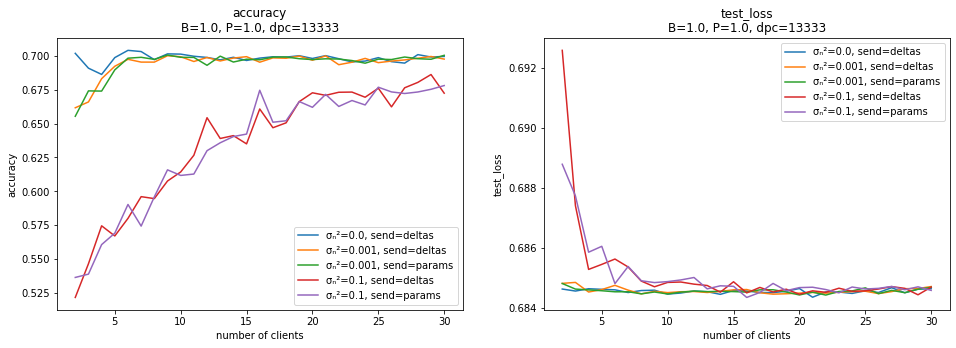

In [11]:
series_specs = {
    'noise': '__all__',
    'send': '__all__',
}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Digital simulations 1

In [12]:
results_dir = Path("../results-downloaded/20210720-stocquant/")

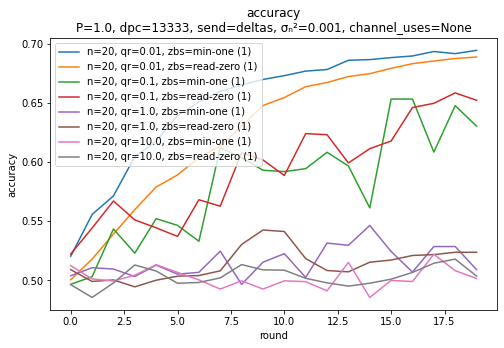

In [13]:
title_specs = {
    'power': 1.0,
    'data_per_client': 13333,
    'send': 'deltas',
    'noise': 0.001,
    'channel_uses': None,
}
series_specs = {
    'clients': [20],
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

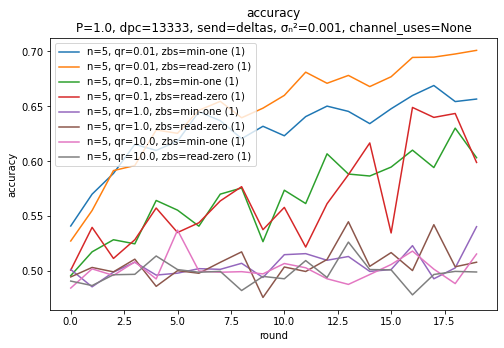

In [14]:
series_specs['clients'] = 5
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

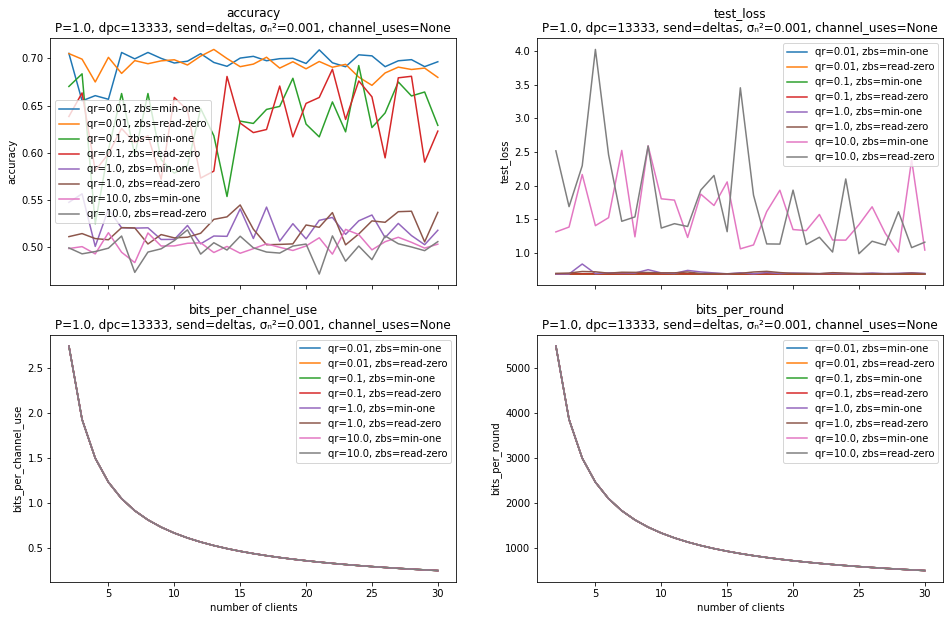

In [15]:
series_specs = {
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy', 'test_loss', 'bits_per_channel_use', 'bits_per_round']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Digital simulations 2

Tried a few different values to see what changes.

In [16]:
results_dir = Path("../results-downloaded/20210721-stocquant/")

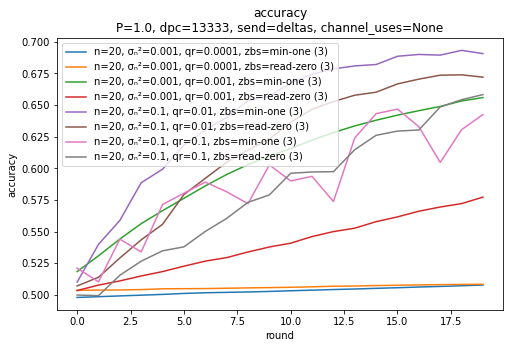

In [17]:
title_specs = {
    'power': 1.0,
    'data_per_client': 13333,
    'send': 'deltas',
    'channel_uses': None,
}
series_specs = {
    'clients': [20],
    'noise': '__all__',
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

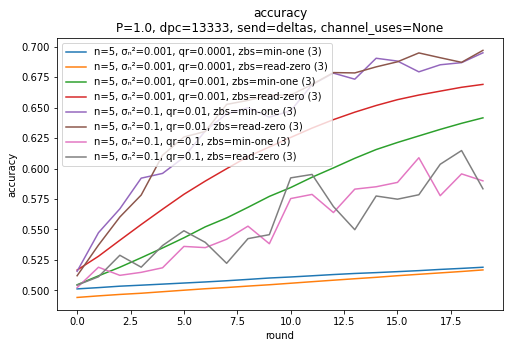

In [18]:
series_specs['clients'] = 5
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

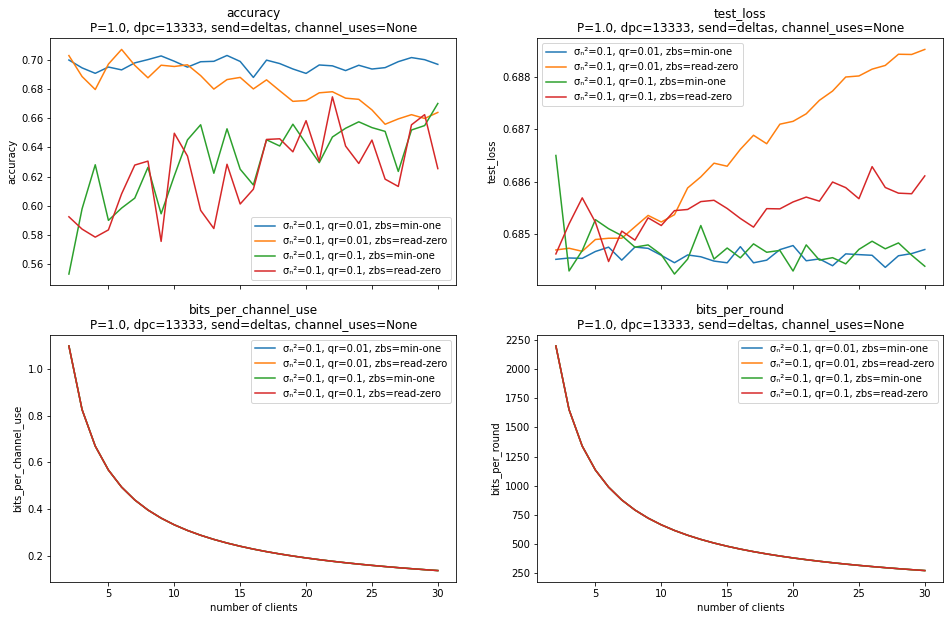

In [19]:
series_specs = {
    'noise': [0.1],
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy', 'test_loss', 'bits_per_channel_use', 'bits_per_round']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

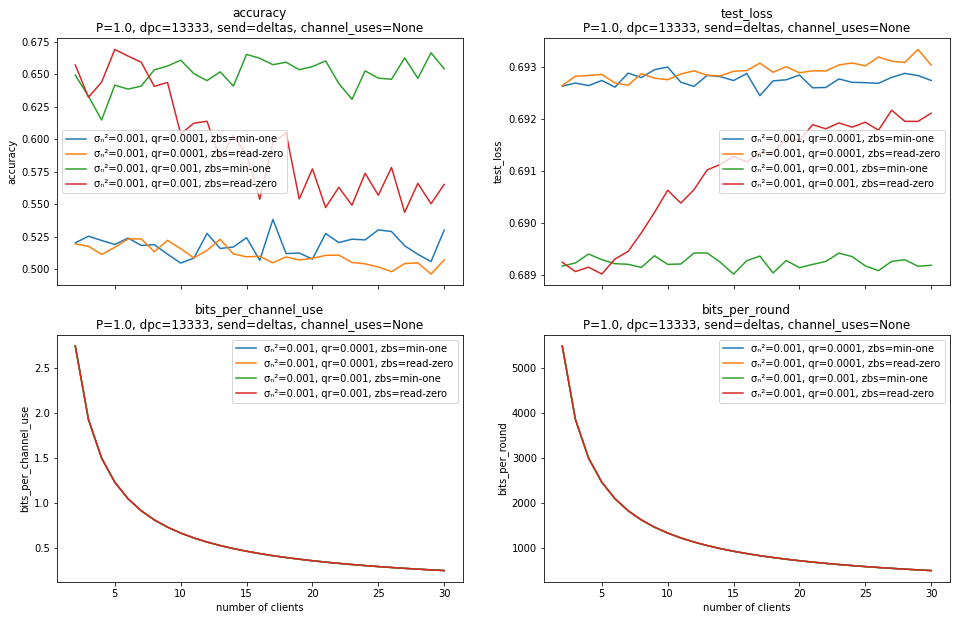

In [20]:
series_specs = {
    'noise': [0.001],
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Digital simulations 1 and 2

In [21]:
results_dir = [Path("../results-downloaded/20210720-stocquant/"), Path("../results-downloaded/20210721-stocquant/")]

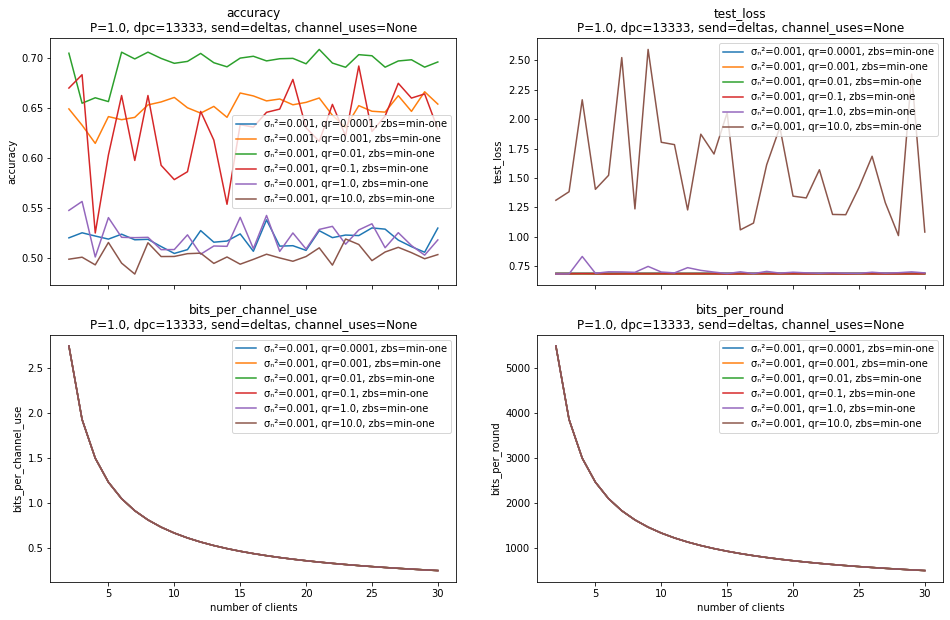

In [22]:
series_specs = {
    'noise': [0.001],
    'quantization_range': '__all__',
    'zero_bits_strategy': 'min-one',
}

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

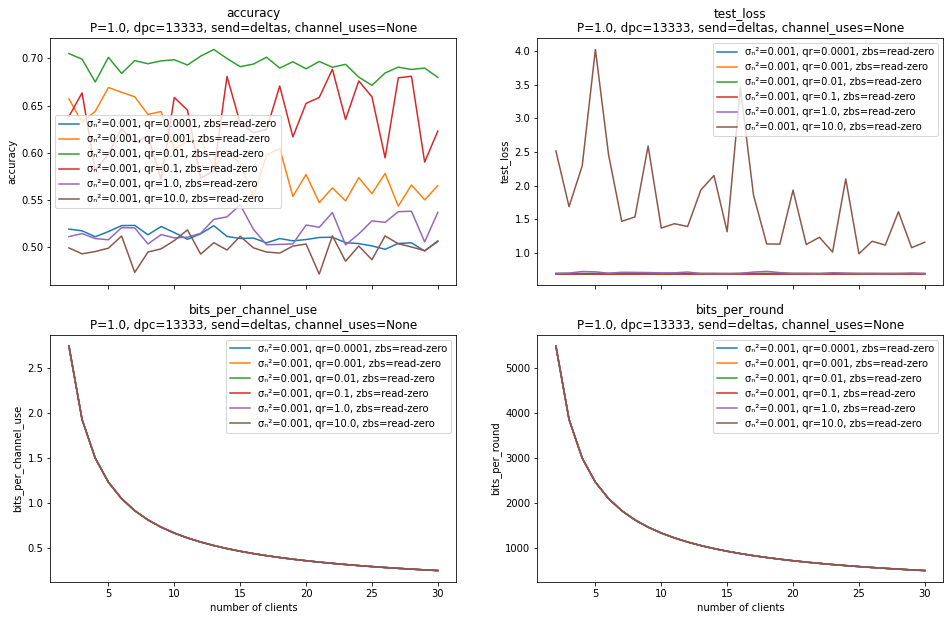

In [23]:
series_specs = {
    'noise': [0.001],
    'quantization_range': '__all__',
    'zero_bits_strategy': 'read-zero',
}

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

Current thinking [22 July]:

- The digital regime is in effect still using a lot more power than the analog scheme, because we are using all of the power in the digital scheme (via the channel capacity), whereas in the analog scheme, we're not intelligently scaling for power, and we can see in the `tx_power_client0` plots that the amount of power actually used is often under 0.001, which is like 1000 times less power than the 1.0 we intended to be using. We could scale digital power down, but we're using only a handful of bits as it is.
- The digital scheme seems passable. Next step is to make sure that power comparison is really fair.
- We'll probably want to do some sort of dynamic power scaling to get that to work. To get things going, say it's fine to assume there's a side-channel that clients can use to communicate what they think $B$ should be.


Which plot?
- The "number of clients" plot isn't as insightful as first appears in this case. At the moment, we're just taking the accuracy after 20 rounds. This cutoff is kind of arbitrarily chosen, and it's quite near the beginning of training.
- Training until convergence doesn't make sense—all of them will (or should) converge to the same place, they'll just take different amounts of time to do so. So we would expect "accuracy at convergence" plots to be flat.
- The better thing to do is probably just to do training plots (accuracy vs round number) for a _fixed_ number of clients, and let that tell the story. It doesn't give as much insight about scaling in $n$, but at least it's harder to suggest that we're cherry-picking the point of measurement.

# Running for longer and with smaller $B$

Possibly a little ambitious, but here we go. These were on commit `28770a4`, before the refactor to add the dynamic power scaling scheme, so it'll be good to check whether the runs on `b3b4f07` (which use the same arguments) behave the same.

The value of $B$ chosen is just $\sqrt{0.00025}$, the square root of the power that appeared to be transmitted in the plots for commit `1b5e659` above.

In [24]:
results_dir = Path("../results-downloaded/20210721-smaller-pr/")

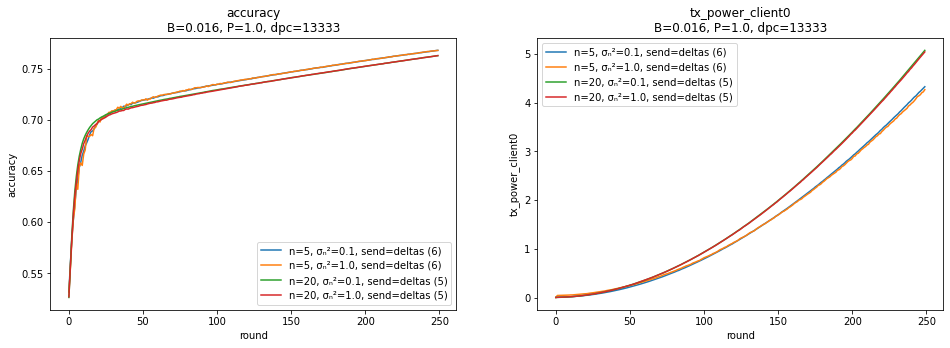

In [25]:
fixed_specs = {
    'rounds': 250,
    'batch_size': 64,
    'lr_client': 0.01,
    'epochs': 1,
    'small': False,
}
title_specs = {
    'parameter_radius': 0.016,
    'power': 1.0,
    'data_per_client': 13333,
}
series_specs = {
    'clients': '__all__',
    'noise': '__all__',
    'send': ['deltas'],
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

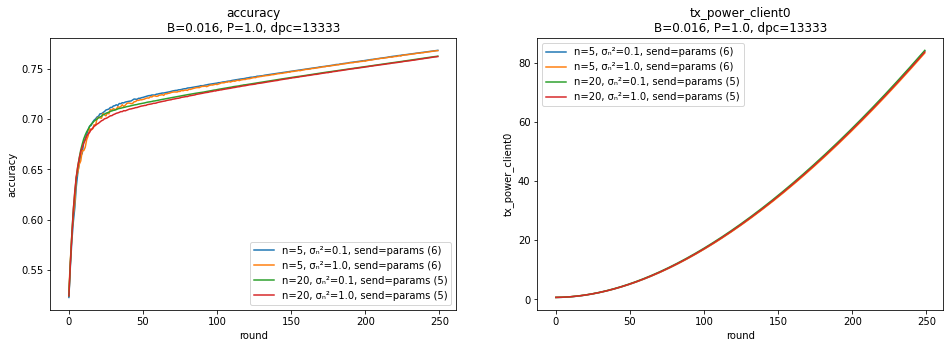

In [26]:
series_specs['send'] = ['params']
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

What I predicted about how attempting to scale $B$ by the order of magnitude predicted above would have second-order effects that made the estimate invalid turned out to be correct. We noticed in `ota-basic.ipynb` that the transmit power tends to increase as the model trains, because the model weights increase (from zero) towards their eventual value. So what's happening here is, the model is training faster, which in turn causes it to consume more power—which is why is quite quickly appears to spiral out of control. Recall that in `ota-basic.ipynb`, when we trained it until convergence, we found that the maximum power would imply $B = 3.4$, _i.e._ the power we were using before was _too much_, despite its appearing to be miniscule.

To confirm that this wasn't just my calculation of $B$ being incorrect, here are the same plots, but zoomed into rounds 1–20, which is the same number of rounds we were using before. Notice that the transmit power seems to be around 1.0, as expected:

(0.0, 2.0)

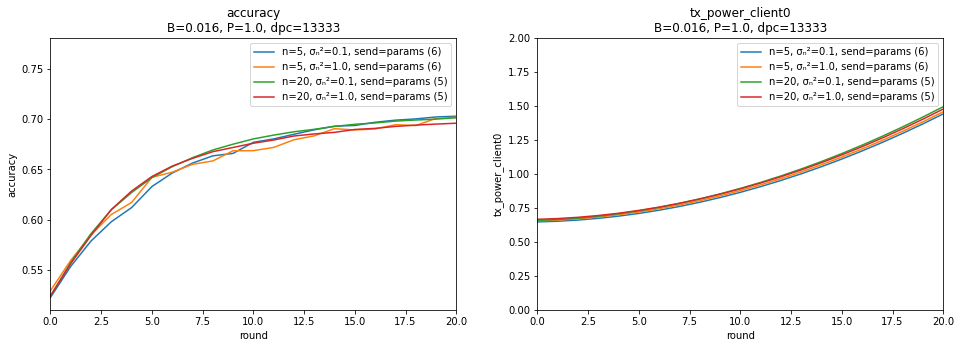

In [27]:
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)
plt.xlim((0, 20))
plt.ylim((0, 2))

To do something satisfying we'll need to control power dynamically, having it react to the current values that clients are attempting to send, if possible.